In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import gseapy as gp

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import json 

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [3]:
# Hypothesis: Although transferred cells have higher proportion of B cell neighbors,
# they are not being activated (hence the degs). 
# Show: 
# 1. Heatmap of degs for all and high confidence logfoldchange
# 2. Neighborhood proportions
# 3. Localization of all and transferred cells wrt to B and DC cells

In [4]:
transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymph1_transferred.txt', dtype=str)
ko_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO4_transferred.txt', dtype=str)
ko2_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO2_transferred.txt', dtype=str)

len(transferred), len(ko_transferred), len(ko2_transferred)

(488, 632, 517)

In [5]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

#### 1. DEGs

In [6]:
workdir = '../../notebooks/mouse_lymphnode_visiumHD/slide_runs_ko'

tfh_degs = pd.read_csv(f'{workdir}/consistent_degs_Tfh.csv', index_col=0)
tfh_degs_all = pd.read_csv(f'{workdir}/consistent_degs_Tfh_all.csv', index_col=0)
th2_degs = pd.read_csv(f'{workdir}/consistent_degs_Th2.csv', index_col=0)
th2_degs_all = pd.read_csv(f'{workdir}/consistent_degs_Th2_all.csv', index_col=0)

In [7]:
def volcano_plot(de_df, degs, ax, title, xlim=None, ylim=None):
    # volcano plot: x=logfoldchange, y=-log10(pval_adj)
    x = de_df['logfoldchanges']
    y = -np.log10(de_df['pvals_adj'].replace(0, 1e-300))

    sig_mask = de_df['names'].isin(degs.index)
    nonsig_mask = ~sig_mask

    ax.scatter(x[nonsig_mask], y[nonsig_mask], c='lightgray', s=10, alpha=0.7, edgecolor='none')
    ax.scatter(x[sig_mask], y[sig_mask], c='blue', s=15, alpha=0.8, edgecolor='none')
    ax.scatter(x[de_df['names'].isin(['Ccr4'])], y[de_df['names'].isin(['Ccr4'])], c='crimson', s=15, alpha=0.8, edgecolor='black')

    # Label genes in degs, color Ccr4 in red, others in black
    for idx, row in pd.concat([de_df[sig_mask], de_df[de_df['names'].isin(['Ccr4'])]]).iterrows():
        gene = row['names']
        color = 'black'
        if abs(row.logfoldchanges) > 1 or gene == 'Ccr4':
            ax.text(
                row['logfoldchanges'],
                -np.log10(row['pvals_adj'] if row['pvals_adj'] > 0 else 1e-300),
                gene,
                fontsize=8,
                color=color,
                ha='right' if row['logfoldchanges'] < 0 else 'left',
                va='center'
            )
    ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
    ax.axvline(1, color='gray', linestyle='--', linewidth=1)
    ax.axvline(-1, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel('log$_2$ fold change')
    ax.set_ylabel('-log$_{10}$ adj. p-value')
    ax.set_title(title)

    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [8]:
def plot_enrichment_bar(df, title, n_terms=5, color='#4C72B0'):
    df_plot = df.sort_values('Adjusted P-value').head(n_terms)
    df_plot['-log10(Adj P-value)'] = -np.log10(df_plot['Adjusted P-value'].replace(0, np.nanmin(df_plot['Adjusted P-value'][df_plot['Adjusted P-value']>0])/10))
    plt.figure(figsize=(7, 0.5 * n_terms + 2))
    sns.barplot(
        data=df_plot,
        y='Term',
        x='-log10(Adj P-value)',
        color=color,
        edgecolor='k'
    )
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('')
    plt.title(title)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

In [9]:
dc_degs = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/slide_runs_ko/consistent_degs_DC_all.csv', index_col=0)
down_degs = dc_degs[dc_degs['logfoldchanges_ko2'] < 0].index.tolist()
up_degs = dc_degs[dc_degs['logfoldchanges_ko2'] > 0].index.tolist()

In [11]:
import gseapy as gp 
gp.get_library_name(organism='mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre

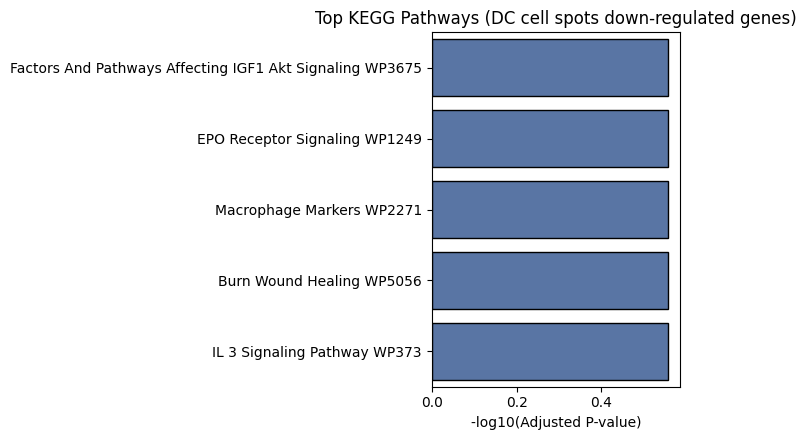

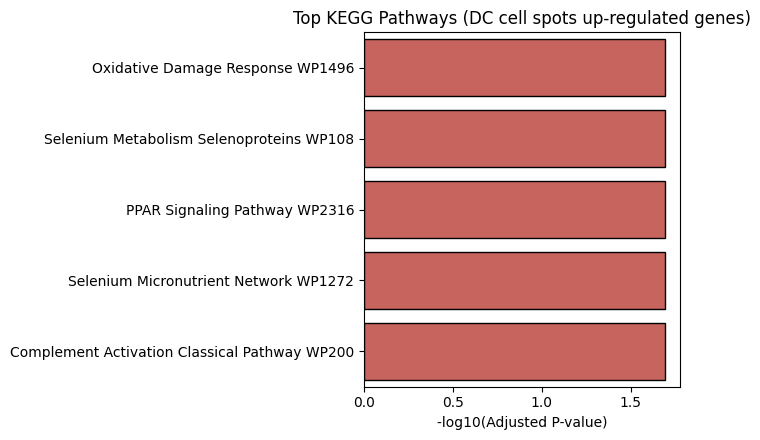

In [12]:
import gseapy as gp

# gene_set = 'KEGG_2019_Mouse'
gene_set = 'WikiPathways_2024_Mouse'

# Down-regulated enrichment
enr_down = gp.enrichr(
    gene_list=down_degs,
    gene_sets=gene_set,
    organism='Mouse',
    background=adata_control.var_names.tolist(),
    outdir=None
)
enrichment_df_down = enr_down.results

# Up-regulated enrichment
enr_up = gp.enrichr(
    gene_list=up_degs,
    gene_sets=gene_set,
    organism='Mouse',
    background=adata_control.var_names.tolist(),
    outdir=None
)
enrichment_df_up = enr_up.results

plot_enrichment_bar(enrichment_df_down, 'Top KEGG Pathways (DC cell spots down-regulated genes)', color='#4C72B0')
plot_enrichment_bar(enrichment_df_up, 'Top KEGG Pathways (DC cell spots up-regulated genes)', color='#D9544D')

In [13]:
enrichment_df_down

Gene_set  \
0   WikiPathways_2024_Mouse   
1   WikiPathways_2024_Mouse   
2   WikiPathways_2024_Mouse   
3   WikiPathways_2024_Mouse   
4   WikiPathways_2024_Mouse   
5   WikiPathways_2024_Mouse   
6   WikiPathways_2024_Mouse   
7   WikiPathways_2024_Mouse   
8   WikiPathways_2024_Mouse   
9   WikiPathways_2024_Mouse   
10  WikiPathways_2024_Mouse   
11  WikiPathways_2024_Mouse   
12  WikiPathways_2024_Mouse   
13  WikiPathways_2024_Mouse   
14  WikiPathways_2024_Mouse   
15  WikiPathways_2024_Mouse   
16  WikiPathways_2024_Mouse   
17  WikiPathways_2024_Mouse   
18  WikiPathways_2024_Mouse   

                                                 Term   P-value  \
0                        IL 3 Signaling Pathway WP373  0.033503   
1                           Burn Wound Healing WP5056  0.043330   
2                           Macrophage Markers WP2271  0.057365   
3                       EPO Receptor Signaling WP1249  0.071201   
4   Factors And Pathways Affecting IGF1 Akt Signal...  0.124606   
5      Microglia Pathogen Phagocytosis Pathway WP3626  0.137486   
6     Alpha 6 Beta 4 Integrin Signaling Pathway WP488  0.150182   
7   Fibrin Complement Receptor 3 Signaling Pathway...  0.162697   
8           Cytokines And Inflammatory Response WP222  0.162697   
9                        IL 5 Signaling Pathway WP151  0.162697   
10                      Alzheimer 39 S Disease WP2075  0.175033   
11                       IL 2 Signaling Pathway WP450  0.175033   
12                         ID Signaling Pathway WP512  0.210997   
13                Delta Notch Signaling Pathway WP265  0.245442   
14                Integrin Mediated Cell Adhesion WP6  0.278429   
15                             Insulin Signaling WP65  0.289111   
16                                Focal Adhesion WP85  0.396964   
17                 Chemokine Signaling Pathway WP2292  0.448931   
18  Focal Adhesion PI3K Akt mTOR Signaling Pathway...  0.580139   

    Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0           0.277136            0                     0    7.919540   
1           0.277136            0                     0   34.716667   
2           0.277136            0                     0   23.133333   
3           0.277136            0                     0   17.341667   
4           0.277136            0                     0    8.654167   
5           0.277136            0                     0    7.688889   
6           0.277136            0                     0    6.916667   
7           0.277136            0                     0    6.284848   
8           0.277136            0                     0    6.284848   
9           0.277136            0                     0    6.284848   
10          0.277136            0                     0    5.758333   
11          0.277136            0                     0    5.758333   
12          0.308380            0                     0    4.600000   
13          0.333099            0                     0    3.827778   
14          0.343319            0                     0    3.276190   
15          0.343319            0                     0    3.125758   
16          0.443665            0                     0    2.072727   
17          0.473872            0                     0    1.748718   
18          0.580139            0                     0    1.185965   

    Combined Score       Genes  
0        26.895600  SYK;FCER2A  
1       108.972441      PECAM1  
2        66.122322        CD74  
3        45.820892       PTPRC  
4        18.023157      IGFBP7  
5        15.256576         SYK  
6        13.113379       ITGA6  
7        11.412453         SYK  
8        11.412453      H2-EB1  
9        11.412453         SYK  
10       10.035501         APP  
11       10.035501         SYK  
12        7.157189        PAX5  
13        5.376866         APP  
14        4.188915       ITGA6  
15        3.878892        CAP1  
16        1.915015       ITGA6  
17        1.400523      CCL21A  
18       

In [14]:
b_degs = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/slide_runs_ko/consistent_degs_B_all.csv', index_col=0)
down_degs = b_degs[b_degs['logfoldchanges_ko2'] < 0].index.tolist()
up_degs = b_degs[b_degs['logfoldchanges_ko2'] > 0].index.tolist()

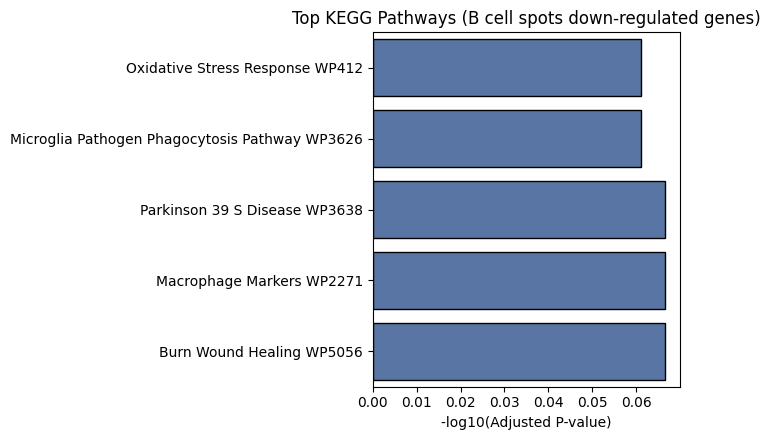

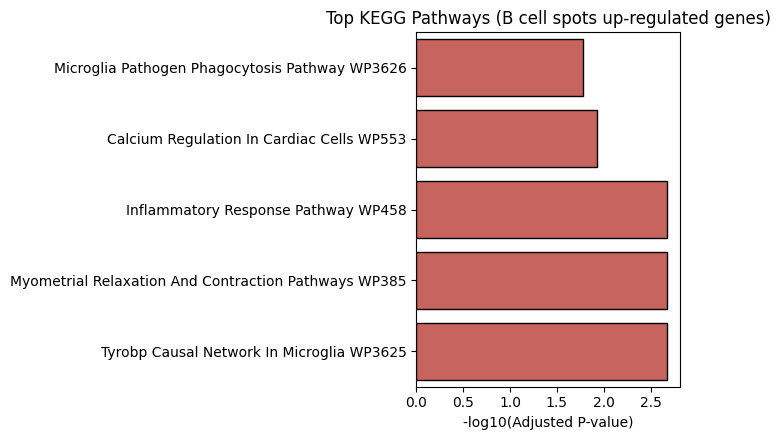

In [15]:
enr_down = gp.enrichr(
    gene_list=down_degs,
    gene_sets=gene_set,
    organism='Mouse',
    background=adata_control.var_names.tolist(),
    outdir=None
)
enrichment_df_down = enr_down.results

enr_up = gp.enrichr(
    gene_list=up_degs,
    gene_sets=gene_set,
    organism='Mouse',
    background=adata_control.var_names.tolist(),
    outdir=None
)
enrichment_df_up = enr_up.results

plot_enrichment_bar(enrichment_df_down, 'Top KEGG Pathways (B cell spots down-regulated genes)', color='#4C72B0')
plot_enrichment_bar(enrichment_df_up, 'Top KEGG Pathways (B cell spots up-regulated genes)', color='#D9544D')

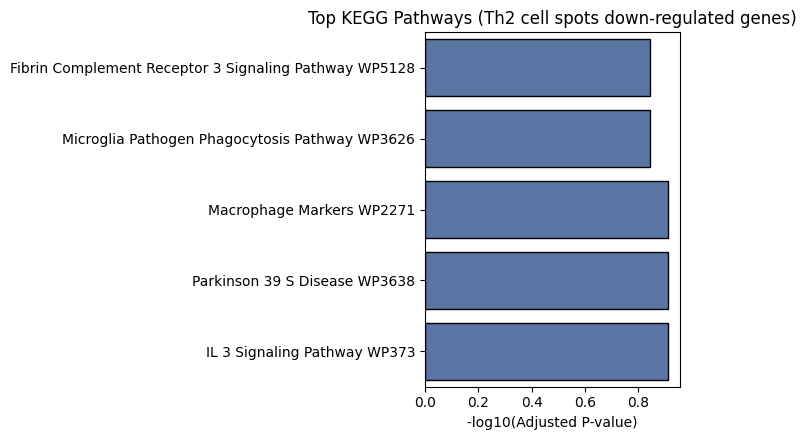

In [16]:
th_degs = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/slide_runs_ko/consistent_degs_Th2_all.csv', index_col=0)
down_degs = th_degs[th_degs['logfoldchanges_ko2'] < 0].index.tolist()

enr_down = gp.enrichr(
    gene_list=down_degs,
    gene_sets=gene_set,
    organism='Mouse',
    background=adata_control.var_names.tolist(),
    outdir=None
)
enrichment_df_down = enr_down.results
plot_enrichment_bar(enrichment_df_down, 'Top KEGG Pathways (Th2 cell spots down-regulated genes)', color='#4C72B0')

In [17]:
enrichment_df_down

Gene_set                                               Term  \
0  WikiPathways_2024_Mouse                       IL 3 Signaling Pathway WP373   
1  WikiPathways_2024_Mouse                      Parkinson 39 S Disease WP3638   
2  WikiPathways_2024_Mouse                          Macrophage Markers WP2271   
3  WikiPathways_2024_Mouse     Microglia Pathogen Phagocytosis Pathway WP3626   
4  WikiPathways_2024_Mouse  Fibrin Complement Receptor 3 Signaling Pathway...   
5  WikiPathways_2024_Mouse          Cytokines And Inflammatory Response WP222   
6  WikiPathways_2024_Mouse                       IL 5 Signaling Pathway WP151   
7  WikiPathways_2024_Mouse                       IL 2 Signaling Pathway WP450   
8  WikiPathways_2024_Mouse                         ID Signaling Pathway WP512   

    P-value  Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0  0.017510          0.122917            0                     0   11.533333   
1  0.040972          0.122917            0                     0   33.190476   
2  0.040972          0.122917            0                     0   33.190476   
3  0.099439          0.143304            0                     0   11.031746   
4  0.118161          0.143304            0                     0    9.017316   
5  0.118161          0.143304            0                     0    9.017316   
6  0.118161          0.143304            0                     0    9.017316   
7  0.127381          0.143304            0                     0    8.261905   
8  0.154495          0.154495            0                     0    6.600000   

   Combined Score       Genes  
0       46.651913  SYK;FCER2A  
1      106.038982       LRRK2  
2      106.038982        CD74  
3       25.463557         SYK  
4       19.258377         SYK  
5       19.258377      H2-EB1  
6       19.258377         SYK  
7       17.024233         SYK  
8       12.326134        PAX5

In [18]:
# cell_type = 'Th2'

# celltype_adata = sc.concat([
#     adata_control[adata_control.obs.cell_type == cell_type],
#     adata_ko[adata_ko.obs.cell_type == cell_type],
#     adata_ko2[adata_ko2.obs.cell_type == cell_type]
# ])
# sc.tl.rank_genes_groups(
#     celltype_adata,
#     groupby='tissue',
#     reference='lymph1',
#     method='wilcoxon',
#     pts=True,
#     layer='normalized_count'
# )

# celltype_adata_trans = sc.concat([
#     adata_control[adata_control.obs.index.isin(transferred)],
#     adata_ko[adata_ko.obs.index.isin(ko_transferred)],
#     adata_ko2[adata_ko2.obs.index.isin(ko2_transferred)]
# ])
# sc.tl.rank_genes_groups(
#     celltype_adata_trans,
#     groupby='tissue',
#     reference='lymph1',
#     method='wilcoxon',
#     pts=True,
#     layer='normalized_count'
# )
# degs_ko4_df = sc.get.rank_genes_groups_df(celltype_adata, group='lymphKO4')
# degs_ko2_df = sc.get.rank_genes_groups_df(celltype_adata, group='lymphKO2')
# degs_ko4_trans_df = sc.get.rank_genes_groups_df(celltype_adata_trans, group='lymphKO4')
# degs_ko2_trans_df = sc.get.rank_genes_groups_df(celltype_adata_trans, group='lymphKO2')

# fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=120)
# axs = axs.flatten()
# volcano_plot(degs_ko4_df, th2_degs, axs[0], 'Lymph KO4 vs Control Th2', xlim=(-20, 4), ylim=None)
# volcano_plot(degs_ko2_df, th2_degs, axs[1], 'Lymph KO2 vs Control Th2', xlim=(-20, 4), ylim=None)
# volcano_plot(degs_ko4_trans_df, th2_degs, axs[2], 'Lymph KO4 vs Control Th2 (transferred)', xlim=(-20, 4), ylim=None)
# volcano_plot(degs_ko2_trans_df, th2_degs, axs[3], 'Lymph KO2 vs Control Th2 (transferred)', xlim=(-20, 4), ylim=None)

# plt.tight_layout()
# plt.show()


#### DC subtype proportions

In [19]:
import decoupler as dc
import json

with open('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/reactome/m2.cp.biocarta.v2025.1.Mm.json', 'r') as f:
    reactome_data = json.load(f)

reactome = []
for pathway, info in reactome_data.items():
    for gene in info['geneSymbols']:
        reactome.append({
            'geneset': pathway,
            'genesymbol': gene
        })
reactome = pd.DataFrame(reactome)
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]

hallmark = reactome
hallmark.columns = ['source', 'target']

In [20]:
relevant = [x for x in hallmark.source.unique() if ('_IL' in x or 'IFN' in x)]
hallmark = hallmark[hallmark.source.isin(relevant)]
hallmark.source.unique()

array(['BIOCARTA_IL17_PATHWAY', 'BIOCARTA_IL2_PATHWAY',
       'BIOCARTA_IL3_PATHWAY', 'BIOCARTA_IL4_PATHWAY',
       'BIOCARTA_IL5_PATHWAY', 'BIOCARTA_IL6_PATHWAY',
       'BIOCARTA_IL10_PATHWAY', 'BIOCARTA_IL12_PATHWAY',
       'BIOCARTA_IL2RB_PATHWAY', 'BIOCARTA_IL22BP_PATHWAY',
       'BIOCARTA_IL7_PATHWAY', 'BIOCARTA_IL1R_PATHWAY',
       'BIOCARTA_IFNA_PATHWAY', 'BIOCARTA_IFNG_PATHWAY'], dtype=object)

In [21]:
adata_dc = sc.concat([
    adata_control[adata_control.obs['cell_type'] == 'DC'], 
    adata_ko[adata_ko.obs['cell_type'] == 'DC'], 
    adata_ko2[adata_ko2.obs['cell_type'] == 'DC']
], axis=0)

adata_dc.X = adata_dc.layers['normalized_count']

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


2025-08-04 13:28:00,850 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-04 13:28:08,091 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-04 13:28:08,123 - harmonypy - INFO - Iteration 1 of 30
2025-08-04 13:28:09,595 - harmonypy - INFO - Iteration 2 of 30
2025-08-04 13:28:10,983 - harmonypy - INFO - Iteration 3 of 30
2025-08-04 13:28:12,337 - harmonypy - INFO - Iteration 4 of 30
2025-08-04 13:28:13,792 - harmonypy - INFO - Iteration 5 of 30
2025-08-04 13:28:15,197 - harmonypy - INFO - Iteration 6 of 30
2025-08-04 13:28:16,627 - harmonypy - INFO - Iteration 7 of 30
2025-08-04 13:28:17,999 - harmonypy - INFO - Iteration 8 of 30
2025-08-04 13:28:18,916 - harmonypy - INFO - Iteration 9 of 30
2025-08-04 13:28:19,908 - harmonypy - INFO - Iteration 10 of 30
2025-08-04 13:28:20,661 - harmonypy - INFO - Iteration 11 of 30
2025-08-04 13:28:21,498 - harmonypy - INFO - Iteration 12 of 30
2025-08-04 13:28:22,241 - harmonypy - INFO - Iteration 13 of

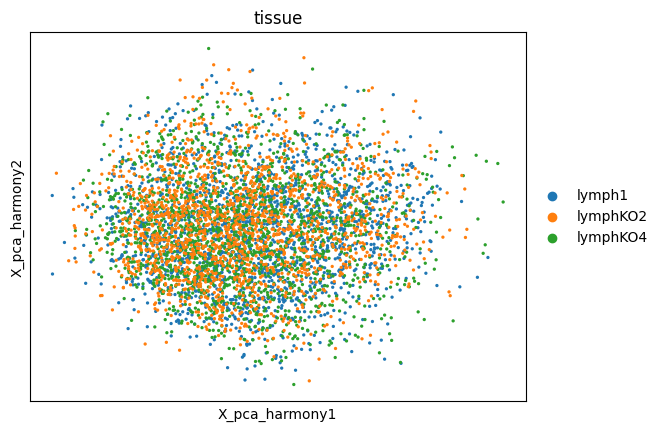

2025-08-04 13:28:34.430783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-04 13:28:34.961778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/

In [22]:
sc.pp.pca(adata_dc, n_comps=10)

import harmonypy as hm

# Run Harmony on the PCA embedding
ho = hm.run_harmony(adata_dc.obsm['X_pca'], adata_dc.obs, 'tissue', max_iter_harmony=30)
adata_dc.obsm['X_pca_harmony'] = ho.Z_corr.T
sc.pl.embedding(adata_dc, 'X_pca_harmony', color=['tissue'])

sc.pp.neighbors(adata_dc, use_rep='X_pca_harmony')
sc.tl.umap(adata_dc)

/tmp/ipykernel_3675/1083783436.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_dc, resolution=0.6)


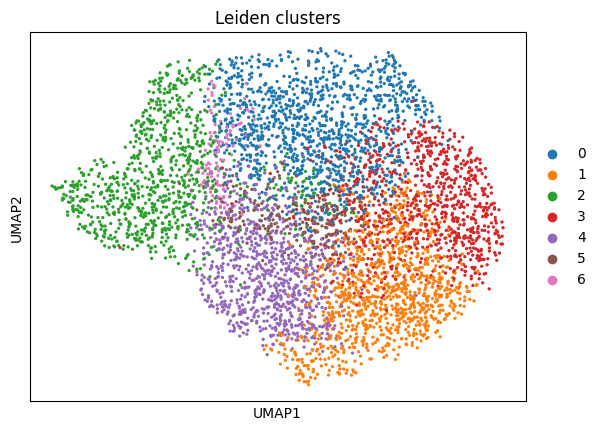

In [23]:
sc.tl.leiden(adata_dc, resolution=0.6)
sc.pl.umap(adata_dc, color='leiden', title='Leiden clusters', use_raw=False)

In [24]:
leiden_order = sorted(adata_dc.obs['leiden'].unique(), key=lambda x: int(x))
pd.concat([
    adata_dc[adata_dc.obs['leiden'] == leiden_label].obs['tissue'].value_counts() 
    for leiden_label in leiden_order
], axis=1).set_axis(leiden_order, axis=1)

0    1    2    3    4   5   6
tissue                                   
lymphKO4  427  387  241  308  323  86  39
lymph1    409  312  386  238  332  98  32
lymphKO2  389  375  269  346  224  80  37

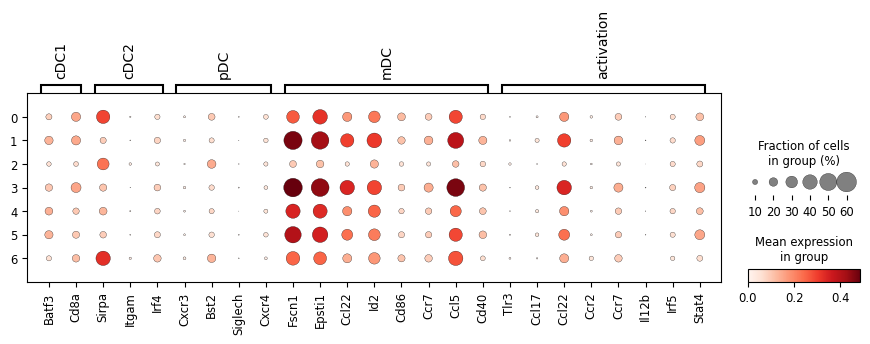

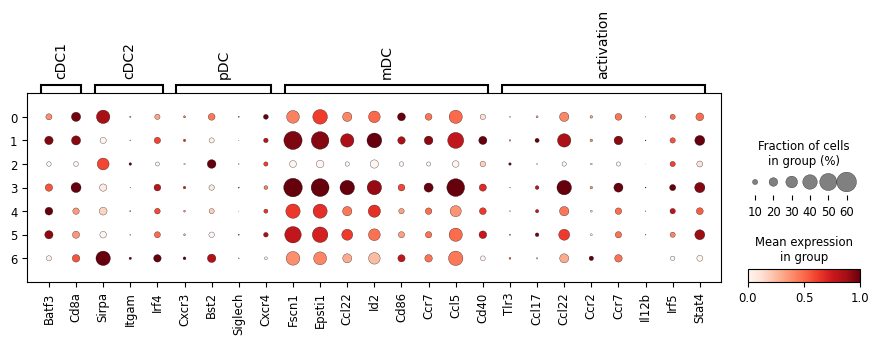

In [25]:
markers = {
    "cDC1": ['Batf3', 'Irf8', 'Cd8a'],
    "cDC2": ['Sirpa', 'Itgam', 'Irf4', 'Clec10a'],
    "pDC": ['Siglech', 'Bst2', 'Tcf4', 'Irf7', 'Ly6d', 'Cxcr3', 'Cxcr4'],
    "mDC": ['Fscn1', 'Ccl5', 'Ccl22', 'Epsti1', 'Ccr7', 'Cd83', 'Cd40', 'Cd86', 'Id2'],
    'activation': ['Nfkb', 'Irf5', 'Stat4', 'Tlr3', 'Ccr2', 'Ccl17', 'Ccl22', 'Ccr7', 'Il12b']
}

markers = {k: list(set(v) & set(adata_dc.var_names)) for k, v in markers.items()}
sc.pl.dotplot(adata_dc, markers, groupby='leiden')

markers = {k: list(set(v) & set(adata_dc.var_names)) for k, v in markers.items()}
sc.pl.dotplot(adata_dc, markers, groupby='leiden', standard_scale='var')

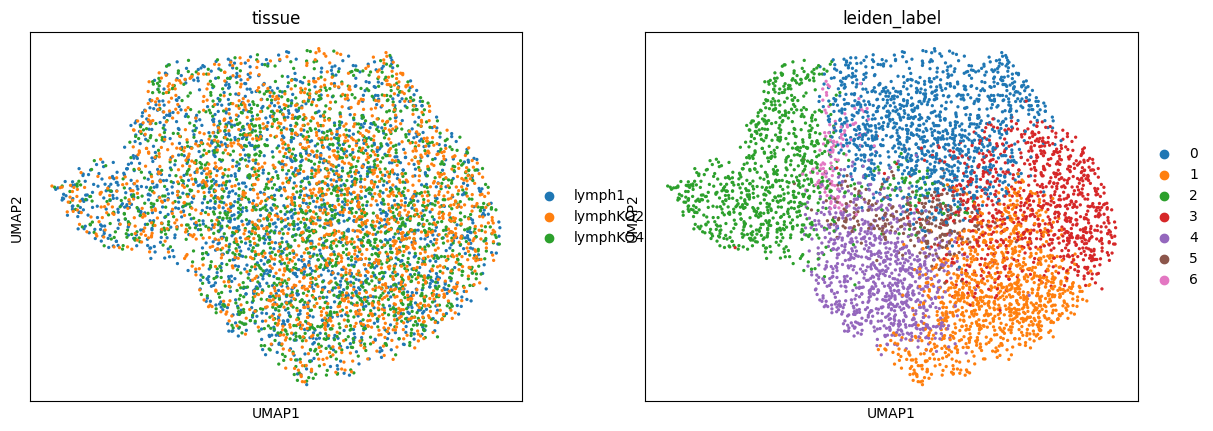

3    4    0    1    2   5   6
tissue                                   
lymphKO2  346  224  389  375  269  80  37
lymphKO4  308  323  427  387  241  86  39
lymph1    238  332  409  312  386  98  32

In [26]:
adata_dc.obs['leiden_label'] = adata_dc.obs['leiden']
sc.pl.umap(adata_dc, color=['tissue', 'leiden_label'])

dc_proportions = pd.concat([
    adata_dc[adata_dc.obs['leiden_label'] == leiden_label].obs['tissue'].value_counts() 
    for leiden_label in adata_dc.obs['leiden_label'].unique()
], axis=1).set_axis(adata_dc.obs['leiden_label'].unique(), axis=1)

dc_proportions


In [27]:
def assign_leiden_label(target_adata, dc_adata, tissue_name):
    leiden_series = dc_adata[dc_adata.obs['tissue'] == tissue_name].obs['leiden_label']
    leiden_series = leiden_series.reindex(target_adata.obs.index, axis=0)
    if pd.api.types.is_categorical_dtype(leiden_series):
        if 'not_DC' not in leiden_series.cat.categories:
            leiden_series = leiden_series.cat.add_categories(['not_DC'])
    leiden_series = leiden_series.fillna('not_DC')
    target_adata.obs['leiden_label'] = leiden_series

assign_leiden_label(adata_control, adata_dc, 'lymph1')
assign_leiden_label(adata_ko, adata_dc, 'lymphKO2')
assign_leiden_label(adata_ko2, adata_dc, 'lymphKO3')

full_adata = sc.concat([adata_control, adata_ko, adata_ko2], axis=0)

/tmp/ipykernel_3675/1997127765.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(leiden_series):
/tmp/ipykernel_3675/1997127765.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(leiden_series):
/tmp/ipykernel_3675/1997127765.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(leiden_series):
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [28]:
full_adata.X = full_adata.layers['normalized_count']

In [29]:
# Get DEGs for each cluster (leiden_label)
degs_per_cluster = {}
for cluster in adata_dc.obs['leiden_label'].unique():
    # Compare this cluster vs all others
    sc.tl.rank_genes_groups(
        full_adata, 
        groupby='leiden_label', 
        groups=[cluster], 
        reference='rest', 
        method='wilcoxon', 
        use_raw=False, 
        n_genes=100
    )
    # Extract results for this cluster
    degs = sc.get.rank_genes_groups_df(full_adata, group=cluster)
    degs_per_cluster[cluster] = degs

In [30]:
for cluster, deg_df in degs_per_cluster.items():
    print(cluster, deg_df.head(20).names.values)


3 ['Ccl21a' 'Cacnb3' 'C3' 'Fscn1' 'Clu' 'Cst3' 'Fn1' 'Ccl5' 'Tmem176a'
 'Marcksl1' 'Ccl22' 'Marcks' 'Rogdi' 'Vim' 'Epsti1' 'Crip1' 'Fabp5'
 'Igfbp7' 'Itm2c' 'Apoe']
4 ['Fabp5' 'H2-Eb1' 'H2-Aa' 'Tmem176b' 'Tmem176a' 'Cacnb3' 'Anxa3' 'S100a4'
 'Marcks' 'Cd74' 'Rogdi' 'Fscn1' 'Vim' 'H2-Ab1' 'Relb' 'Slc4a8' 'Epsti1'
 'Marcksl1' 'Lrrk1' 'Tagln2']
0 ['Apoe' 'Lyz2' 'Selenop' 'Dnase1l3' 'C3' 'C1qa' 'Ctsb' 'Psap' 'Ccl21a'
 'Tmem176a' 'Sirpa' 'Csf1r' 'Tmem176b' 'Pla2g2d' 'Fabp5' 'Cd63' 'Cfp'
 'Anxa3' 'Cfb' 'Rogdi']
1 ['Cacnb3' 'Fscn1' 'Fabp5' 'Cst3' 'Tmem176a' 'Tmem176b' 'Marcksl1' 'Relb'
 'Epsti1' 'S100a4' 'Marcks' 'Anxa3' 'Ccl22' 'Rogdi' 'Rab8b' 'Vim' 'H2-Q7'
 'Basp1' 'Gadd45b' 'Crip1']
2 ['Igfbp7' 'Clu' 'App' 'Pecam1' 'C3' 'Egfl7' 'Vim' 'Cfb' 'Lyz2' 'Tmem176a'
 'Ccl21a' 'Hspg2' 'Tmem176b' 'Epas1' 'Apoe' 'Cdh5' 'Serpinb1a' 'Il6st'
 'Ctla2a' 'Esam']
5 ['Ccl21a' 'Clu' 'C3' 'Fabp5' 'Tmem176a' 'Fn1' 'H2-Eb1' 'Tmem176b' 'H2-Aa'
 'Marcks' 'Cacnb3' 'Rogdi' 'S100a4' 'Fscn1' 'Ptms' 'Vim' 'Anxa3' 'Cd44'

In [ ]:
mapping = {
    '0': 'phagocytic DCs',
    '1': 'activated DCs',
    '2': 'migratory DCs',
    '3': 'Ccr7+ migratory DCs',
    '4': 'antigen-presenting DCs',
    '5': ''
    '6':
}

In [31]:
for cluster, deg_df in degs_per_cluster.items():
    print(cluster, deg_df.head(15).names.values)


3 ['Ccl21a' 'Cacnb3' 'C3' 'Fscn1' 'Clu' 'Cst3' 'Fn1' 'Ccl5' 'Tmem176a'
 'Marcksl1' 'Ccl22' 'Marcks' 'Rogdi' 'Vim' 'Epsti1']
4 ['Fabp5' 'H2-Eb1' 'H2-Aa' 'Tmem176b' 'Tmem176a' 'Cacnb3' 'Anxa3' 'S100a4'
 'Marcks' 'Cd74' 'Rogdi' 'Fscn1' 'Vim' 'H2-Ab1' 'Relb']
0 ['Apoe' 'Lyz2' 'Selenop' 'Dnase1l3' 'C3' 'C1qa' 'Ctsb' 'Psap' 'Ccl21a'
 'Tmem176a' 'Sirpa' 'Csf1r' 'Tmem176b' 'Pla2g2d' 'Fabp5']
1 ['Cacnb3' 'Fscn1' 'Fabp5' 'Cst3' 'Tmem176a' 'Tmem176b' 'Marcksl1' 'Relb'
 'Epsti1' 'S100a4' 'Marcks' 'Anxa3' 'Ccl22' 'Rogdi' 'Rab8b']
2 ['Igfbp7' 'Clu' 'App' 'Pecam1' 'C3' 'Egfl7' 'Vim' 'Cfb' 'Lyz2' 'Tmem176a'
 'Ccl21a' 'Hspg2' 'Tmem176b' 'Epas1' 'Apoe']
5 ['Ccl21a' 'Clu' 'C3' 'Fabp5' 'Tmem176a' 'Fn1' 'H2-Eb1' 'Tmem176b' 'H2-Aa'
 'Marcks' 'Cacnb3' 'Rogdi' 'S100a4' 'Fscn1' 'Ptms']
6 ['Ccl21a' 'C3' 'Clu' 'Igkc' 'Apoe' 'Vim' 'Fn1' 'Lyz2' 'Tgfbi' 'Rabgap1l'
 'Vcam1' 'Cd63' 'Ighm' 'Tmem176b' 'Igfbp4']


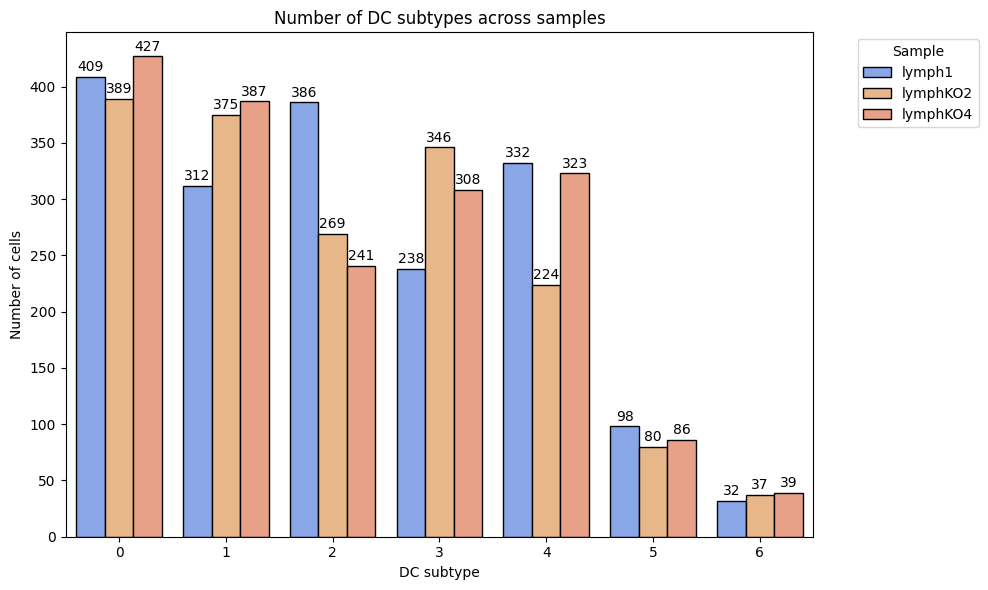

In [32]:
desired_order = adata_dc.obs['leiden_label'].unique()

# Convert 'DC subtype' to a categorical variable with the specified order
dc_long = dc_proportions.reset_index().melt(id_vars='tissue', var_name='DC subtype', value_name='Count')
dc_long['DC subtype'] = pd.Categorical(dc_long['DC subtype'], categories=desired_order, ordered=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=dc_long, 
    x='DC subtype', 
    y='Count', 
    hue='tissue', 
    palette=color_dict,
    edgecolor='black',  # Add black edge outline
    linewidth=1         # Set edge line width
)

# Add the actual number of cells on the bars
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(
            f'{int(height)}', 
            (p.get_x() + p.get_width() / 2., height), 
            ha='center', va='bottom', 
            fontsize=10, color='black', 
            xytext=(0, 2), 
            textcoords='offset points'
        )

# Change legend labels: 'lymph1' -> 'control', 'lymphKO2' -> 'KO1', 'lymphKO3' -> 'KO2'
handles, labels = ax.get_legend_handles_labels()
label_map = {'lymph1': 'control', 'lymphKO2': 'KO1', 'lymphKO3': 'KO2'}
new_labels = [label_map.get(lbl, lbl) for lbl in labels]
ax.legend(handles, new_labels, title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('Number of cells')
plt.xlabel('DC subtype')
plt.title('Number of DC subtypes across samples')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [33]:
dc.mt.ulm(data=adata_dc, net=hallmark)
score = dc.pp.get_obsm(adata=adata_dc, key="score_ulm")
df = dc.tl.rankby_group(adata=score, groupby="leiden_label", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]

n_markers = 10
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)

# Ensure the group order is alphabetical by passing groupby_categories in sorted order
group_order = sorted(score.obs["leiden"].unique(), key=str)
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby="leiden",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
    show=False
)
plt.savefig('figures/DC_pathways.svg', dpi=300, format='svg', bbox_inches='tight', transparent=True)

AttributeError: module 'decoupler' has no attribute 'mt'

In [25]:
# sc.tl.rank_genes_groups(
#     celltype_adata,
#     groupby='tissue',
#     reference='lymph1',
#     method='wilcoxon',
#     pts=True,
#     layer='normalized_count'
# )

# celltype_adata_trans = sc.concat([
#     adata_control[adata_control.obs.index.isin(transferred)],
#     adata_ko[adata_ko.obs.index.isin(ko_transferred)],
#     adata_ko2[adata_ko2.obs.index.isin(ko2_transferred)]
# ])
# sc.tl.rank_genes_groups(
#     celltype_adata_trans,
#     groupby='tissue',
#     reference='lymph1',
#     method='wilcoxon',
#     pts=True,
#     layer='normalized_count'
# )

# degs_ko4_df = sc.get.rank_genes_groups_df(celltype_adata, group='lymphKO4')
# degs_ko2_df = sc.get.rank_genes_groups_df(celltype_adata, group='lymphKO2')

# dc_degs = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/slide_runs_ko/consistent_degs_DC_all.csv', index_col=0)

# fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
# axs = axs.flatten()
# volcano_plot(degs_ko4_df, dc_degs, axs[0], 'Lymph KO4 vs Control B', xlim=(-20, 4), ylim=None)
# volcano_plot(degs_ko2_df, dc_degs, axs[1], 'Lymph KO2 vs Control B', xlim=(-20, 4), ylim=None)

# plt.tight_layout()
# plt.show()


#### 2. neighborhood

In [26]:
from scipy.stats import mannwhitneyu
from matplotlib import gridspec

def plot_neighborhood_boxplots(dicts, dict_names, groups, radii=None, ct_interest='Th2'):
    group_colors = color_dict
    group_colors['control_random'] = color_dict['control']
    group_colors['ko_random'] = color_dict['ko']
    group_colors['ko2_random'] = color_dict['ko2']
    
    if radii is None:
        # Infer radii from first dict
        radii = list(dicts[0].keys())
        # Sort if possible
        try:
            radii = sorted(radii)
        except Exception:
            pass

    # Only 3 subplots (no random)
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), dpi=200)
    axes = axes.flatten()

    # For significance annotation
    def significance_marker(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return None  # Only annotate significant

    for ax, dct, name in zip(axes, dicts, dict_names):
        # Prepare data for boxplot
        boxplot_data = []
        boxplot_positions = []
        boxplot_colors = []
        xtick_labels = []
        xtick_positions = []
        width = 0.2  # width between groups at each radius

        # For significance
        sig_annotations = []

        for i, radius in enumerate(radii):
            group_data = []
            for j, group in enumerate(groups):
                # Offset positions so groups are side-by-side at each radius
                pos = i + (j - 1) * width
                boxplot_positions.append(pos)
                data = dct[radius][group]
                boxplot_data.append(data)
                boxplot_colors.append(group_colors[group])
                group_data.append(data)
            xtick_labels.append(str(radius))
            xtick_positions.append(i)

            # Statistical tests: control vs ko, control vs ko2, ko vs ko2
            # Only if all groups have data
            if all([len(gd) > 0 for gd in group_data]):
                pairs = [(0,1), (0,2), (1,2)]
                for (idx1, idx2) in pairs:
                    data1 = group_data[idx1]
                    data2 = group_data[idx2]
                    try:
                        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
                    except ValueError:
                        pval = 1.0  # fallback if data is not valid
                    marker = significance_marker(pval)
                    if marker is not None:  # Only add if significant
                        # Determine color: blue if left group higher, red if lower
                        mean1 = np.nanmean(data1) if len(data1) > 0 else np.nan
                        mean2 = np.nanmean(data2) if len(data2) > 0 else np.nan
                        if np.isnan(mean1) or np.isnan(mean2):
                            color = 'k'
                        elif mean1 > mean2:
                            color = '#79a1f7'  # blue
                        elif mean1 < mean2:
                            color = 'lightcoral'  # red
                        else:
                            color = 'k'
                        sig_annotations.append({
                            'radius_idx': i,
                            'group1': groups[idx1],
                            'group2': groups[idx2],
                            'pos1': i + (idx1 - 1) * width,
                            'pos2': i + (idx2 - 1) * width,
                            'pval': pval,
                            'marker': marker,
                            'color': color
                        })

        # Draw boxplots
        bp = ax.boxplot(
            boxplot_data,
            positions=boxplot_positions,
            widths=width*0.9,
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='k', linewidth=2),
            boxprops=dict(linewidth=1.5),
            whiskerprops=dict(linewidth=1.2),
            capprops=dict(linewidth=1.2)
        )

        # Color boxes
        for patch, color in zip(bp['boxes'], boxplot_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)
            patch.set_edgecolor('k')
            patch.set_linewidth(1.5)

        # Whiskers and caps
        for whisker in bp['whiskers']:
            whisker.set_color('k')
            whisker.set_linewidth(1.2)
        for cap in bp['caps']:
            cap.set_color('k')
            cap.set_linewidth(1.2)

        # Set x-ticks at center of each radius group
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, fontsize=13)
        ax.set_xlabel('Radius (μm)', fontsize=15, labelpad=8)
        ax.set_title(f'{name} within {ct_interest} neighborhoods', fontsize=16, pad=12)
        ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)

        # Remove top/right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add statistical significance bars (only for significant)
        y_max = np.nanmax([np.nanmax(d) if len(d) > 0 else np.nan for d in boxplot_data])
        y_min = np.nanmin([np.nanmin(d) if len(d) > 0 else np.nan for d in boxplot_data])
        y_range = y_max - y_min if not np.isnan(y_max) and not np.isnan(y_min) else 1
        y_offset = y_range * 0.05
        bar_height = y_max + y_offset if not np.isnan(y_max) else 1

        # For each radius, stack bars if multiple comparisons
        bar_stack = {}  # (radius_idx) -> current bar height

        for ann in sig_annotations:
            r = ann['radius_idx']
            pos1 = ann['pos1']
            pos2 = ann['pos2']
            marker = ann['marker']
            color = ann.get('color', 'k')
            base = bar_stack.get(r, bar_height)
            ax.plot([pos1, pos1, pos2, pos2], [base, base + y_offset, base + y_offset, base], color='k', lw=1.2, zorder=10)
            ax.text((pos1 + pos2) / 2, base + y_offset * 1.1, marker, ha='center', va='bottom', fontsize=15, fontweight='bold', color=color)
            bar_stack[r] = base + y_offset * 1.8

    axes[0].set_ylabel(f'Fraction within {ct_interest} neighborhood', fontsize=15, labelpad=8)

    # Create a custom legend and move it off the plot (right side)
    handles = [
        plt.Line2D([0], [0], color=group_colors[g], lw=8, label=g, alpha=0.8)
        for g in groups
    ]
    legend_ax = fig.add_subplot(axes[2])
    legend_ax.axis('off')
    legend = legend_ax.legend(
        handles=handles,
        title='Group',
        fontsize=14,
        title_fontsize=15,
        loc='center left',
        frameon=False,
        borderaxespad=0.0,
        labelspacing=1.2,
        handlelength=2.5
    )

    plt.tight_layout()
    plt.show()

In [27]:
from collections import defaultdict

def read_spf(radius):
    workdir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD'

    spf_control = pd.read_csv(f'{workdir}/spf_control_{radius}.csv', index_col=0)
    spf_ko = pd.read_csv(f'{workdir}/spf_ko_{radius}.csv', index_col=0)
    spf_ko2 = pd.read_csv(f'{workdir}/spf_ko2_{radius}.csv', index_col=0)

    spf_control.index = spf_control.index.astype(str)
    spf_ko.index = spf_ko.index.astype(str)
    spf_ko2.index = spf_ko2.index.astype(str)

    return {'control': spf_control, 'ko': spf_ko, 'ko2': spf_ko2}

def normalize_rows(df, adata):
    df = df.copy()

    # # normalize each column by total abundance in tissue
    # cell_counts = adata.obs.cell_type.value_counts()
    # cell_counts.rename(index=lambda x: x+'_within', inplace=True)
    # df = df / cell_counts

    # normalize each row to sum to 1 (percentage of ct_within)
    row_sums = df.sum(axis=1)
    df = df.div(row_sums, axis=0)

    return df 


In [28]:
# ctrl_th2 = adata_control[adata_control.obs.cell_type == 'Th2']
# ko_th2 = adata_ko[adata_ko.obs.cell_type == 'Th2']
# ko2_th2 = adata_ko2[adata_ko2.obs.cell_type == 'Th2']

ctrl_th2 = adata_control[adata_control.obs.index.isin(transferred)]
ko_th2 = adata_ko[adata_ko.obs.index.isin(ko_transferred)]
ko2_th2 = adata_ko2[adata_ko2.obs.index.isin(ko2_transferred)]

In [29]:
b_dicts = defaultdict(dict)
dc_dicts = defaultdict(dict)
cd8_dicts = defaultdict(dict)

radii = [50, 100, 150, 200]

for radius in radii:
    spfs = read_spf(radius)

    spf_control = normalize_rows(spfs['control'], adata_control)
    spf_ko = normalize_rows(spfs['ko'], adata_ko)
    spf_ko2 = normalize_rows(spfs['ko2'], adata_ko2)

    b_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['control'] = spf_control.loc[ctrl_th2.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko'] = spf_ko.loc[ko_th2.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko2'] = spf_ko2.loc[ko2_th2.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'B_within'].dropna().values
    dc_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'DC_within'].dropna().values
    cd8_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_th2.obs.index.shape[0]), 'CD8+ T_within'].dropna().values

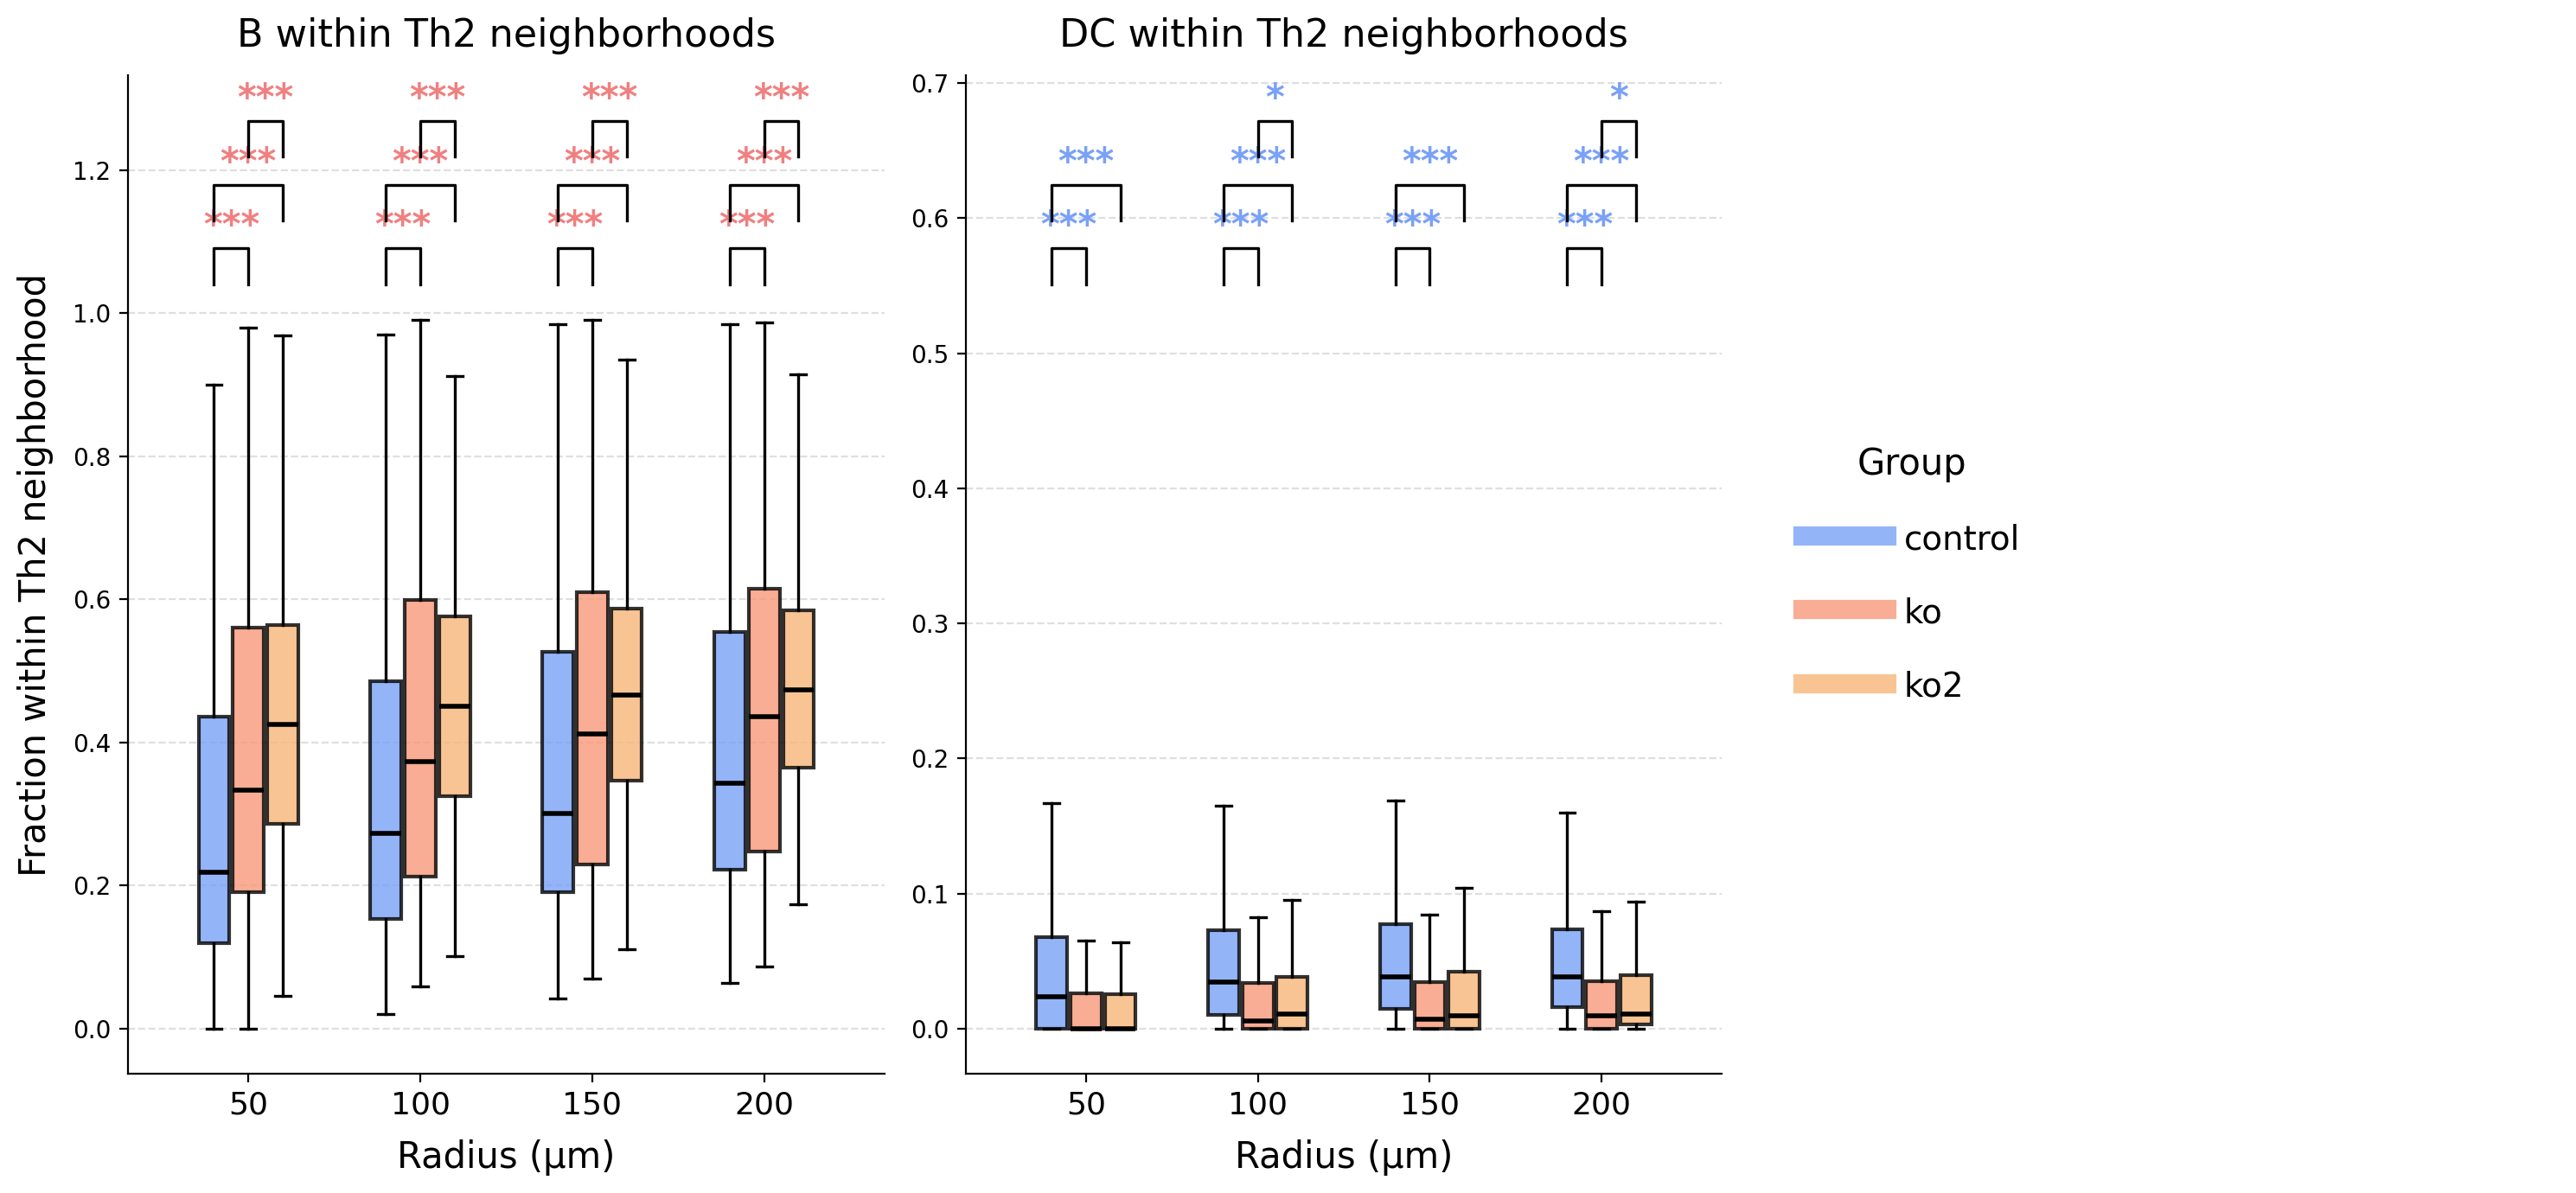

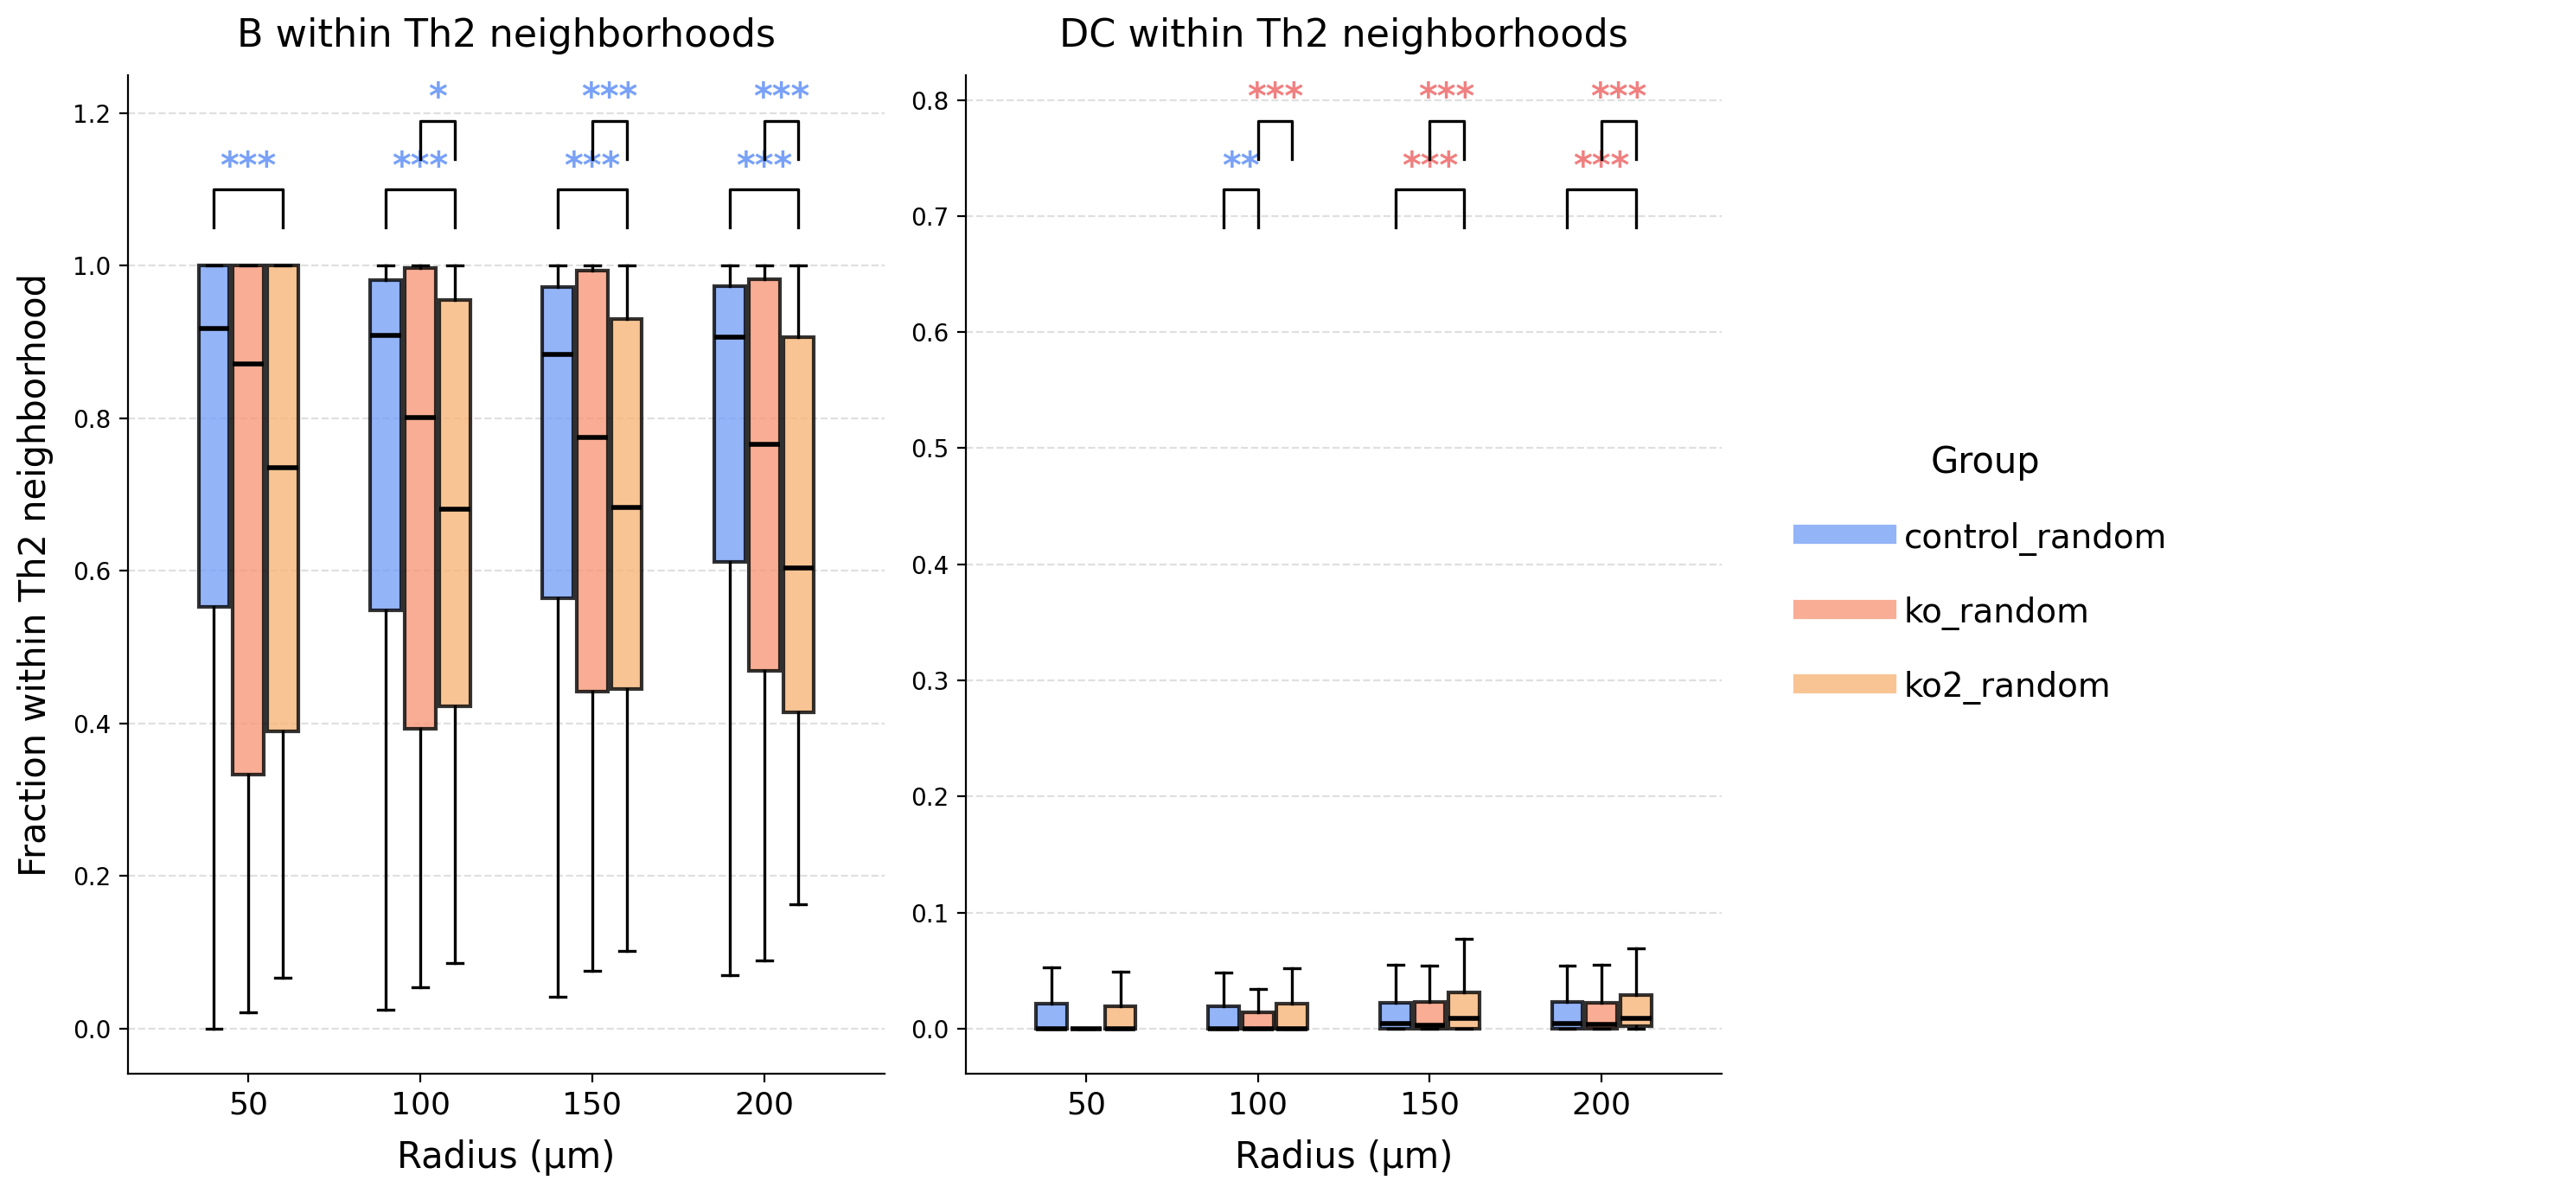

In [30]:
plot_neighborhood_boxplots(
    dicts=[b_dicts, dc_dicts],
    dict_names=['B', 'DC'],
    groups=['control', 'ko', 'ko2'],
    radii=radii
)

plot_neighborhood_boxplots(
    dicts=[b_dicts, dc_dicts],
    dict_names=['B', 'DC'],
    groups=['control_random', 'ko_random', 'ko2_random'],
    radii=radii
)


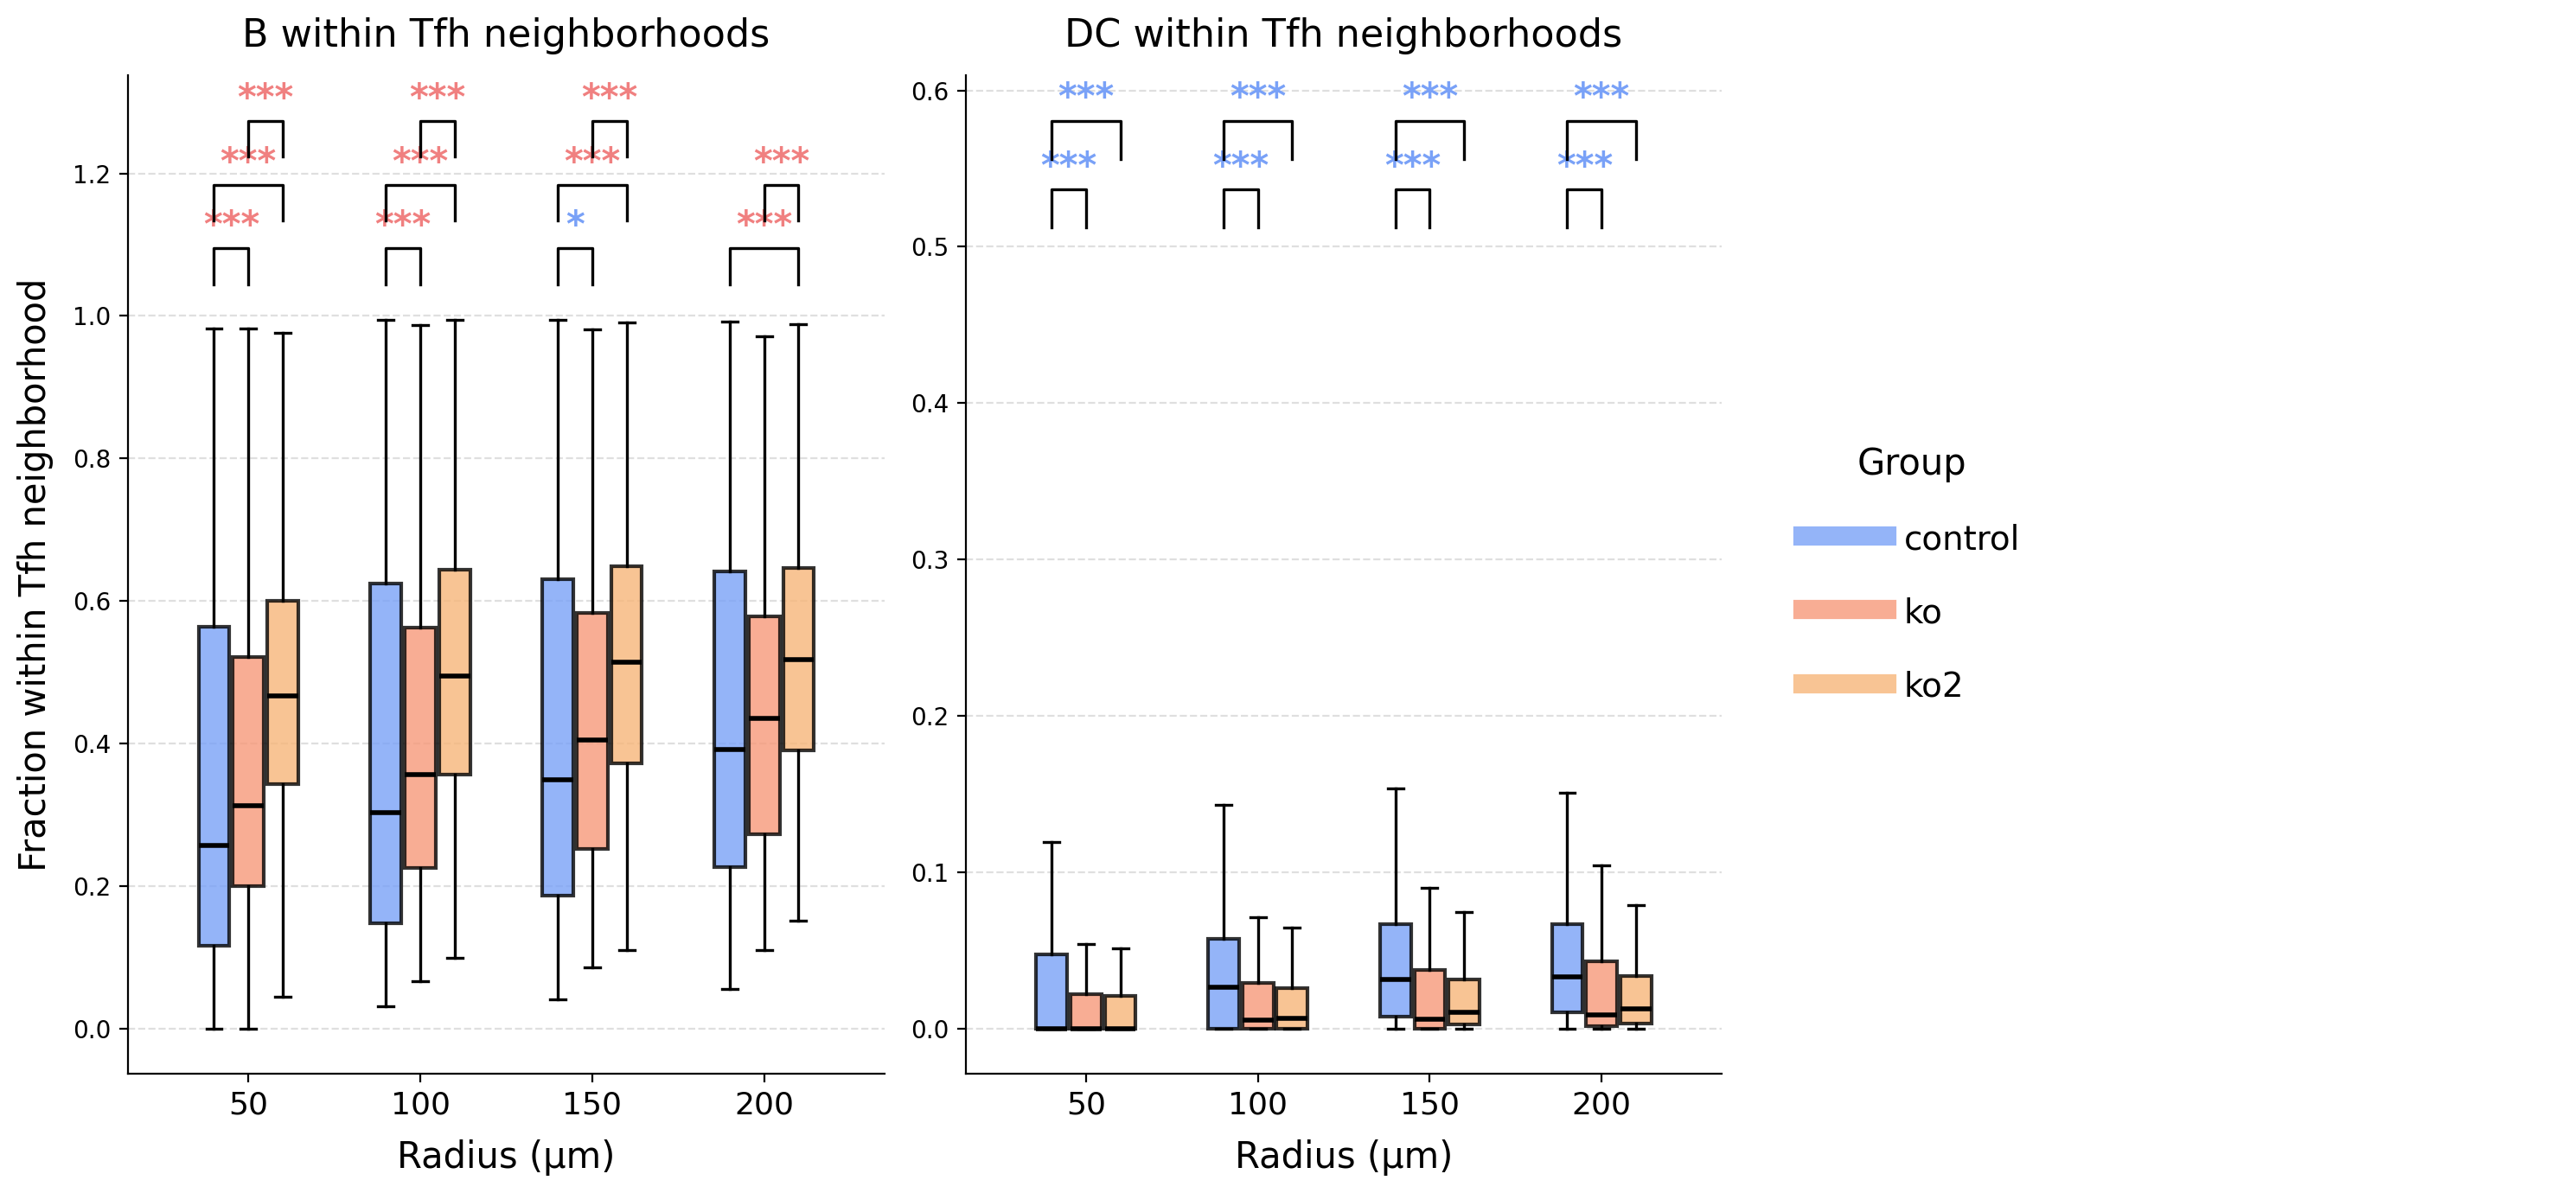

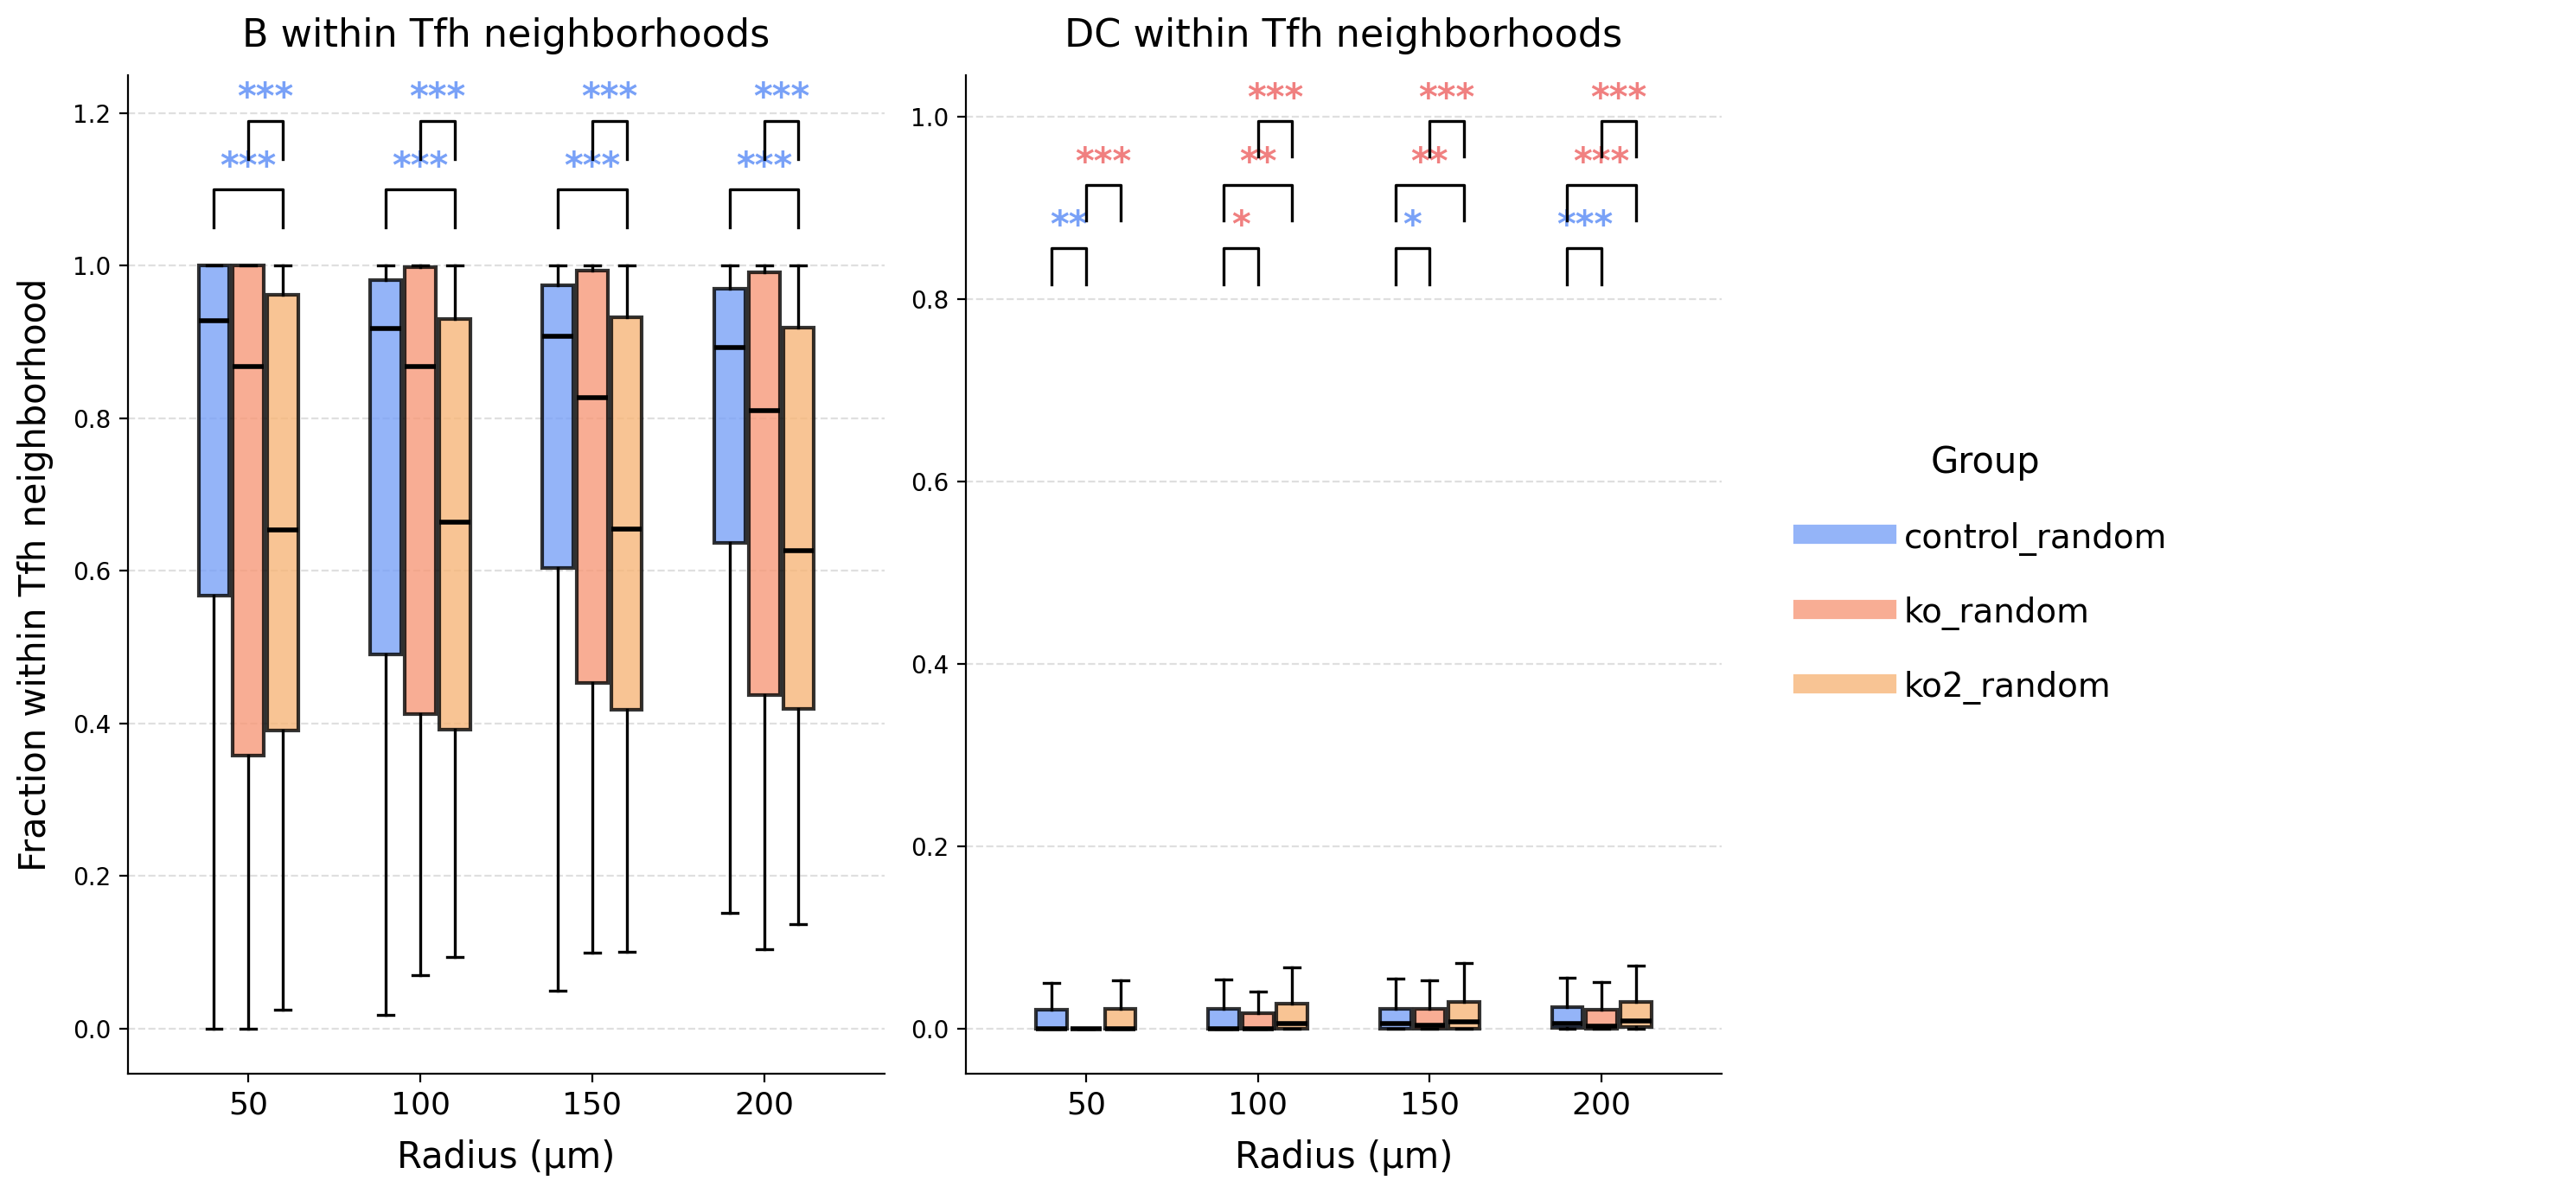

In [31]:
ctrl_tfh = adata_control[adata_control.obs.cell_type == 'Tfh']
ctrl_tfh_trans = adata_control[adata_control.obs.index.isin(transferred)]
ko_tfh = adata_ko[adata_ko.obs.cell_type == 'Tfh']
ko_tfh_trans = adata_ko[adata_ko.obs.index.isin(ko_transferred)]
ko2_tfh = adata_ko2[adata_ko2.obs.cell_type == 'Tfh']
ko2_tfh_trans = adata_ko2[adata_ko2.obs.index.isin(ko2_transferred)]

b_dicts = defaultdict(dict)
dc_dicts = defaultdict(dict)
cd8_dicts = defaultdict(dict)

radii = [50, 100, 150, 200]

for radius in radii:
    spfs = read_spf(radius)

    spf_control = normalize_rows(spfs['control'], adata_control)
    spf_ko = normalize_rows(spfs['ko'], adata_ko)
    spf_ko2 = normalize_rows(spfs['ko2'], adata_ko2)

    b_dicts[radius]['control'] = spf_control.loc[ctrl_tfh.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['control'] = spf_control.loc[ctrl_tfh.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['control'] = spf_control.loc[ctrl_tfh.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['ko'] = spf_ko.loc[ko_tfh.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko'] = spf_ko.loc[ko_tfh.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko'] = spf_ko.loc[ko_tfh.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['ko2'] = spf_ko2.loc[ko2_tfh.obs.index, 'B_within'].dropna().values
    dc_dicts[radius]['ko2'] = spf_ko2.loc[ko2_tfh.obs.index, 'DC_within'].dropna().values
    cd8_dicts[radius]['ko2'] = spf_ko2.loc[ko2_tfh.obs.index, 'CD8+ T_within'].dropna().values

    b_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_tfh.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_tfh.obs.index.shape[0]), 'B_within'].dropna().values
    b_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_tfh.obs.index.shape[0]), 'B_within'].dropna().values
    dc_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_tfh.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_tfh.obs.index.shape[0]), 'DC_within'].dropna().values
    dc_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_tfh.obs.index.shape[0]), 'DC_within'].dropna().values
    cd8_dicts[radius]['control_random'] = spf_control.loc[
        np.random.choice(spf_control.index, size=ctrl_tfh.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko_random'] = spf_ko.loc[
        np.random.choice(spf_ko.index, size=ko_tfh.obs.index.shape[0]), 'CD8+ T_within'].dropna().values
    cd8_dicts[radius]['ko2_random'] = spf_ko2.loc[
        np.random.choice(spf_ko2.index, size=ko2_tfh.obs.index.shape[0]), 'CD8+ T_within'].dropna().values

plot_neighborhood_boxplots(dicts=[b_dicts, dc_dicts],
                               dict_names=['B', 'DC'],
                               groups=['control', 'ko', 'ko2'],
                               radii=radii,
                               ct_interest='Tfh')
                               
plot_neighborhood_boxplots(dicts=[b_dicts, dc_dicts],
                               dict_names=['B', 'DC'],
                               groups=['control_random', 'ko_random', 'ko2_random'],
                               radii=radii,
                               ct_interest='Tfh')


#### Disrupted Ccl17/Ccl22 - Ccr4 interaction?

/tmp/ipykernel_138526/756814885.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_control, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
... storing 'tissue' as categorical


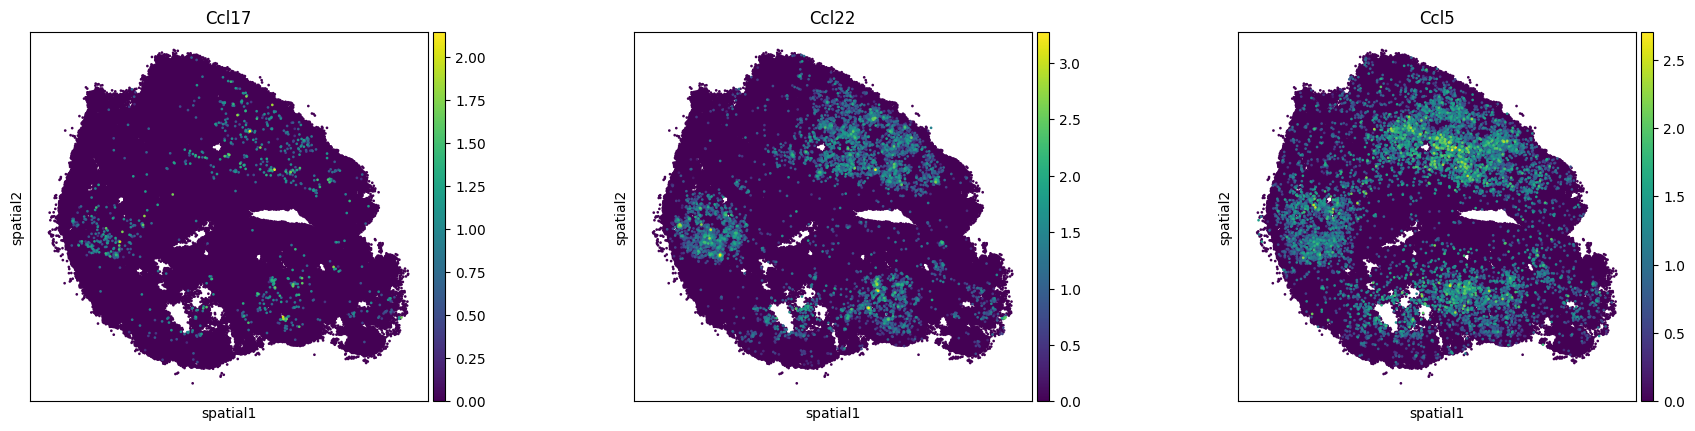

/tmp/ipykernel_138526/756814885.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_ko, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
... storing 'tissue' as categorical


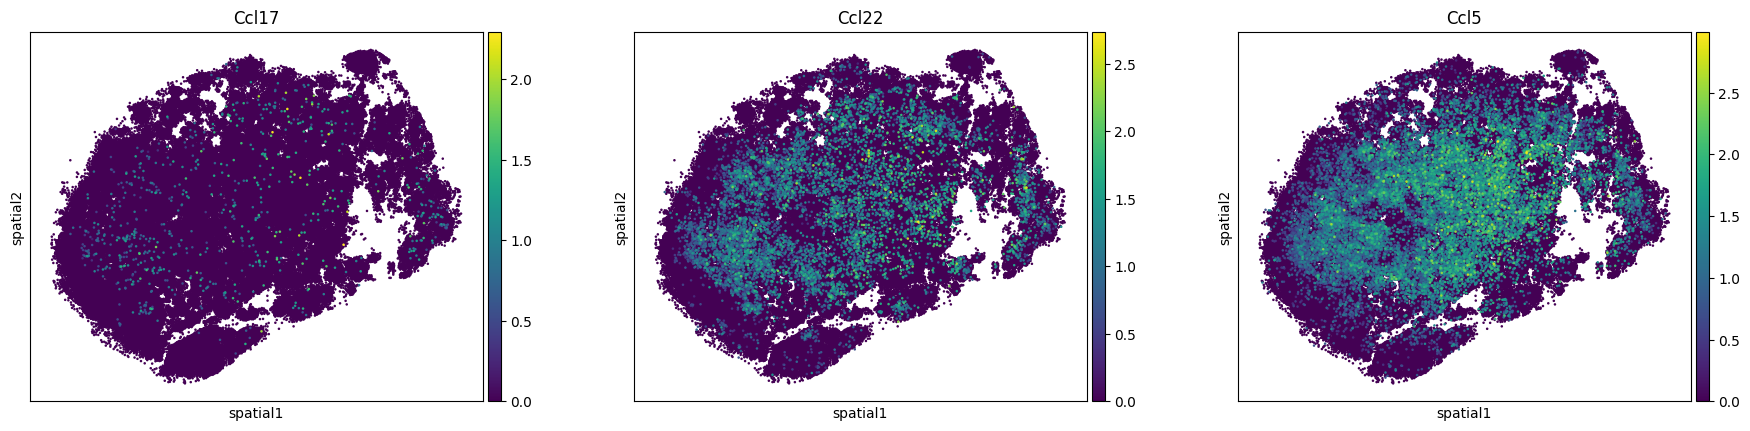

/tmp/ipykernel_138526/756814885.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_ko2, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
... storing 'tissue' as categorical


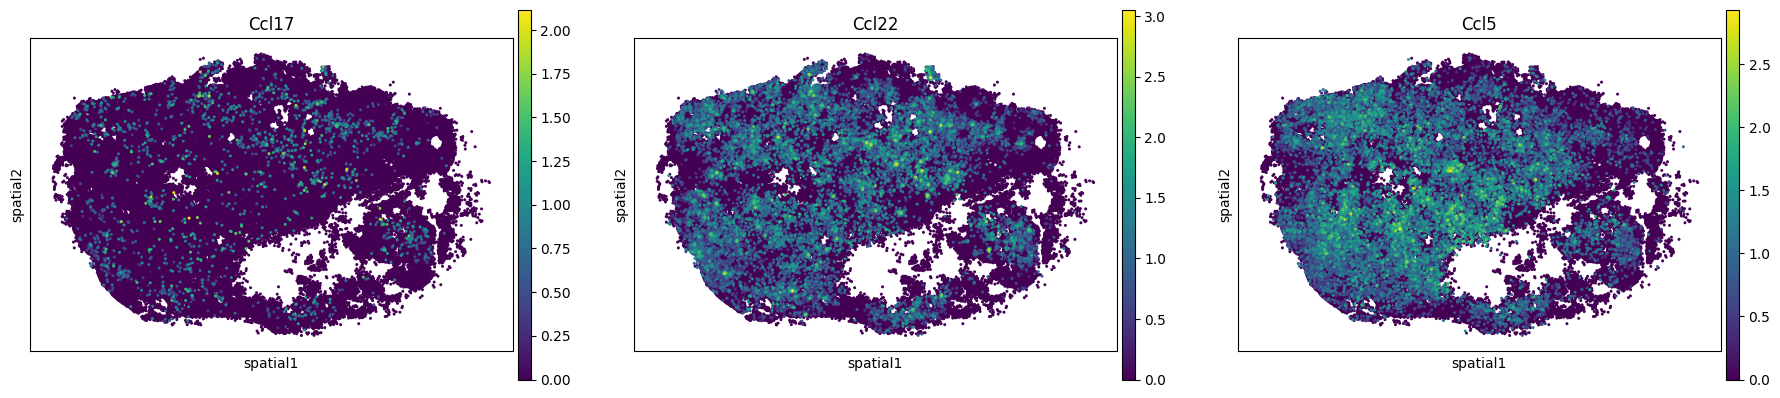

In [32]:
sc.pl.spatial(adata_control, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
sc.pl.spatial(adata_ko, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)
sc.pl.spatial(adata_ko2, color=['Ccl17', 'Ccl22', 'Ccl5'], layer='normalized_count', s=20, spot_size=20)